In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Camera Caliberation Calculation

In [2]:
def get_camera_calibration(images_loc, nx, ny):
    objp = np.zeros((nx * ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    for idx, fname in enumerate(images_loc):
        #print(fname)
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corners
        found, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if found:
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx, dist, rvecs, tvecs

In [3]:
images_file = glob.glob('camera_cal/calibration*.jpg')
cam_mtx, cam_dist, cam_rot, cam_tran = get_camera_calibration(images_file, 9, 6) 

In [4]:
def get_undistored(img, cam_mtx, cam_dist):
    return cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)

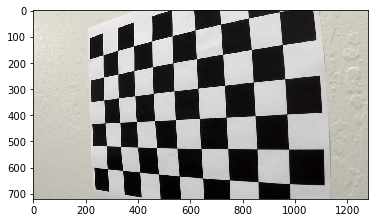

In [5]:
test_img = cv2.imread(images_file[1])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

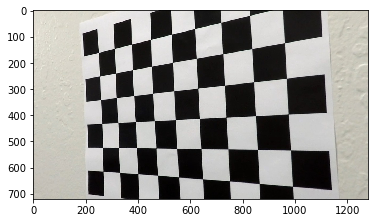

In [6]:
test_img_undist = get_undistored(test_img, cam_mtx, cam_dist)
plt.imshow(test_img_undist)

### Gradient and Thresholding of image

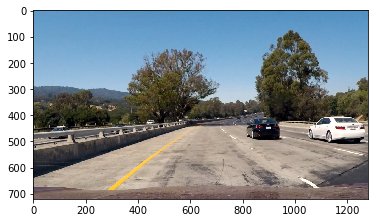

In [7]:
lane_image = cv2.imread('test_images/test1.jpg')
lane_image = cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB)
plt.imshow(lane_image)

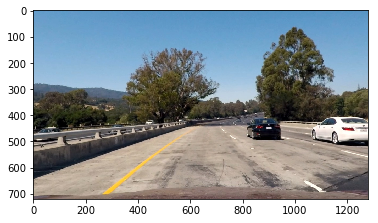

In [8]:
lane_image_undist = get_undistored(lane_image, cam_mtx, cam_dist)
plt.imshow(lane_image_undist)

In [9]:
def magnitude_gradient(img, sobel_kernel=3, thresh_min = 0, thresh_max = 255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Take the gradient in x and y separately
    # Calculate the magnitude 
    sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel_scale = np.uint8(255 * sobel/np.max(sobel)) 
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(sobel_scale)
    # Return this mask as your binary_output image
    binary_output[(sobel_scale > thresh_min) & (sobel_scale <= thresh_max)] = 1
    #binary_output = np.copy(img) # Remove this line
    return binary_output

In [10]:
def direction_gradient(img, sobel_kernel=3, thresh_min=0.0, thresh_max = np.pi/2):
    # Apply the following steps to img
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir > thresh_min) & (grad_dir <= thresh_max)] = 1
    return binary_output

In [11]:
def RGB_image_gradient(img, orient='x', thresh_min = 0, thresh_max = 255):
    # Convert to gray image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Derivative along axis
    if orient == 'x':
        absolute_sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        
    if orient == 'y':
        absolute_sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * absolute_sobel/np.max(absolute_sobel))
    
    # Keeping the derivatives of interest (between of min and max threshold) and converting to binary image
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh_min) & (scaled_sobel < thresh_max)] = 1
    return binary_output
    

In [278]:
def hls_select(img, channel = 's', thresh_min = 0, thresh_max = 255):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    channel_idx = -1
    if channel == 'h':
        channel_idx = 0
    elif channel == 'l':
        channel_idx = 1
    elif channel == 's':
        channel_idx = 2
    channel_img = hls[:,:,channel_idx]
    # Return a binary image of threshold result
    binary_output = np.zeros_like(channel_img)
    binary_output[(channel_img > thresh_min) & (channel_img <= thresh_max)] = 1
    return binary_output

In [279]:
def rgb_select(img, channel = 'r', thresh_min = 0, thresh_max = 255):
    channel_idx = -1
    if channel == 'r':
        channel_idx = 0
    elif channel == 'g':
        channel_idx = 1
    elif channel == 'b':
        channel_idx = 2
    channel_img = img[:,:,channel_idx]
    # Return a binary image of threshold result
    binary_output = np.zeros_like(channel_img)
    binary_output[(channel_img > thresh_min) & (channel_img <= thresh_max)] = 1
    return binary_output

In [280]:
def detect_shape_of_lane(img):
    # S component is indepent of color. This helps to maintains the intensity component intact. 
    s_select_binary = hls_select(img,channel='s', thresh_min=100, thresh_max=255)
    #Also considering the only componenet which has gradient towards x direction
    x_grad_binary = RGB_image_gradient(img=img, orient='x', thresh_min=20, thresh_max=200)
    dir_grad_binary = direction_gradient(img, sobel_kernel=15, thresh_min=0.7, thresh_max=1.5)
    lane_shape = np.zeros_like(x_grad_binary)
    lane_shape[(((x_grad_binary == 1) & (dir_grad_binary == 1)) | (s_select_binary == 1))] = 1
    
    return lane_shape

In [283]:
def detect_color_of_lane(img):
    r_select_binary = rgb_select(img=img, channel='r', thresh_min=160, thresh_max=255)
    g_select_binary = rgb_select(img=img, channel='g', thresh_min=160, thresh_max=255)
    l_remove_shadow = hls_select(img=img, channel='l', thresh_min=110, thresh_max=255)
    lane_color = np.zeros_like(r_select_binary)
    lane_color[(r_select_binary == 1) & (g_select_binary == 1) & (l_remove_shadow == 1)] = 1
    
    return lane_color

In [284]:
def get_thresholded_image(img):
    # Filtering the Color part of Image. Lane could be either White or Green. 
    # This can be retrieved by putting high threshold on Red and Green. 
    # There could also be shadow part in the image. This can be removed by putting higher value on L part of HSL color model
    
    lane_color = detect_color_of_lane(img)
    
    lane_shape = detect_shape_of_lane(img)
    
    output_img = np.zeros_like(lane_shape)
    
    output_img[(lane_color == 1) & ((lane_shape == 1)) ] = 1
    
    return output_img

In [285]:
lane_image = cv2.imread('test_images/straight_lines1.jpg')
#lane_image = cv2.imread('test_images/test4.jpg')
#lane_image = failed_img
lane_image = cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB)
lane_image = failed_img
lane_image_undist = get_undistored(lane_image, cam_mtx, cam_dist)

x_gradient_img = RGB_image_gradient(lane_image_undist, 'x', thresh_min=10, thresh_max=200)

y_gradient_img = RGB_image_gradient(lane_image_undist, 'y', thresh_min=20, thresh_max=200)

magnitude_gradient_img = magnitude_gradient(lane_image_undist)

direction_gradient_img = direction_gradient(lane_image_undist, sobel_kernel=15, thresh_min=0.5, thresh_max=1.5)

s_gradient_img = hls_select(lane_image_undist,channel='s', thresh_min=80, thresh_max=255)

l_gradient_img = hls_select(lane_image_undist, channel='l', thresh_min=110, thresh_max=255)

h_gradient_img = hls_select(lane_image_undist, channel='h', thresh_min=100, thresh_max=170)

r_gradient_img = rgb_select(lane_image_undist, channel='r', thresh_min=160, thresh_max=255)

g_gradient_img = rgb_select(lane_image_undist, channel='g', thresh_min=160, thresh_max=255)

b_gradient_img = rgb_select(lane_image_undist, channel='b', thresh_min=120, thresh_max=255)

lane_shape = detect_shape_of_lane(lane_image_undist)
lane_color = detect_color_of_lane(lane_image_undist)

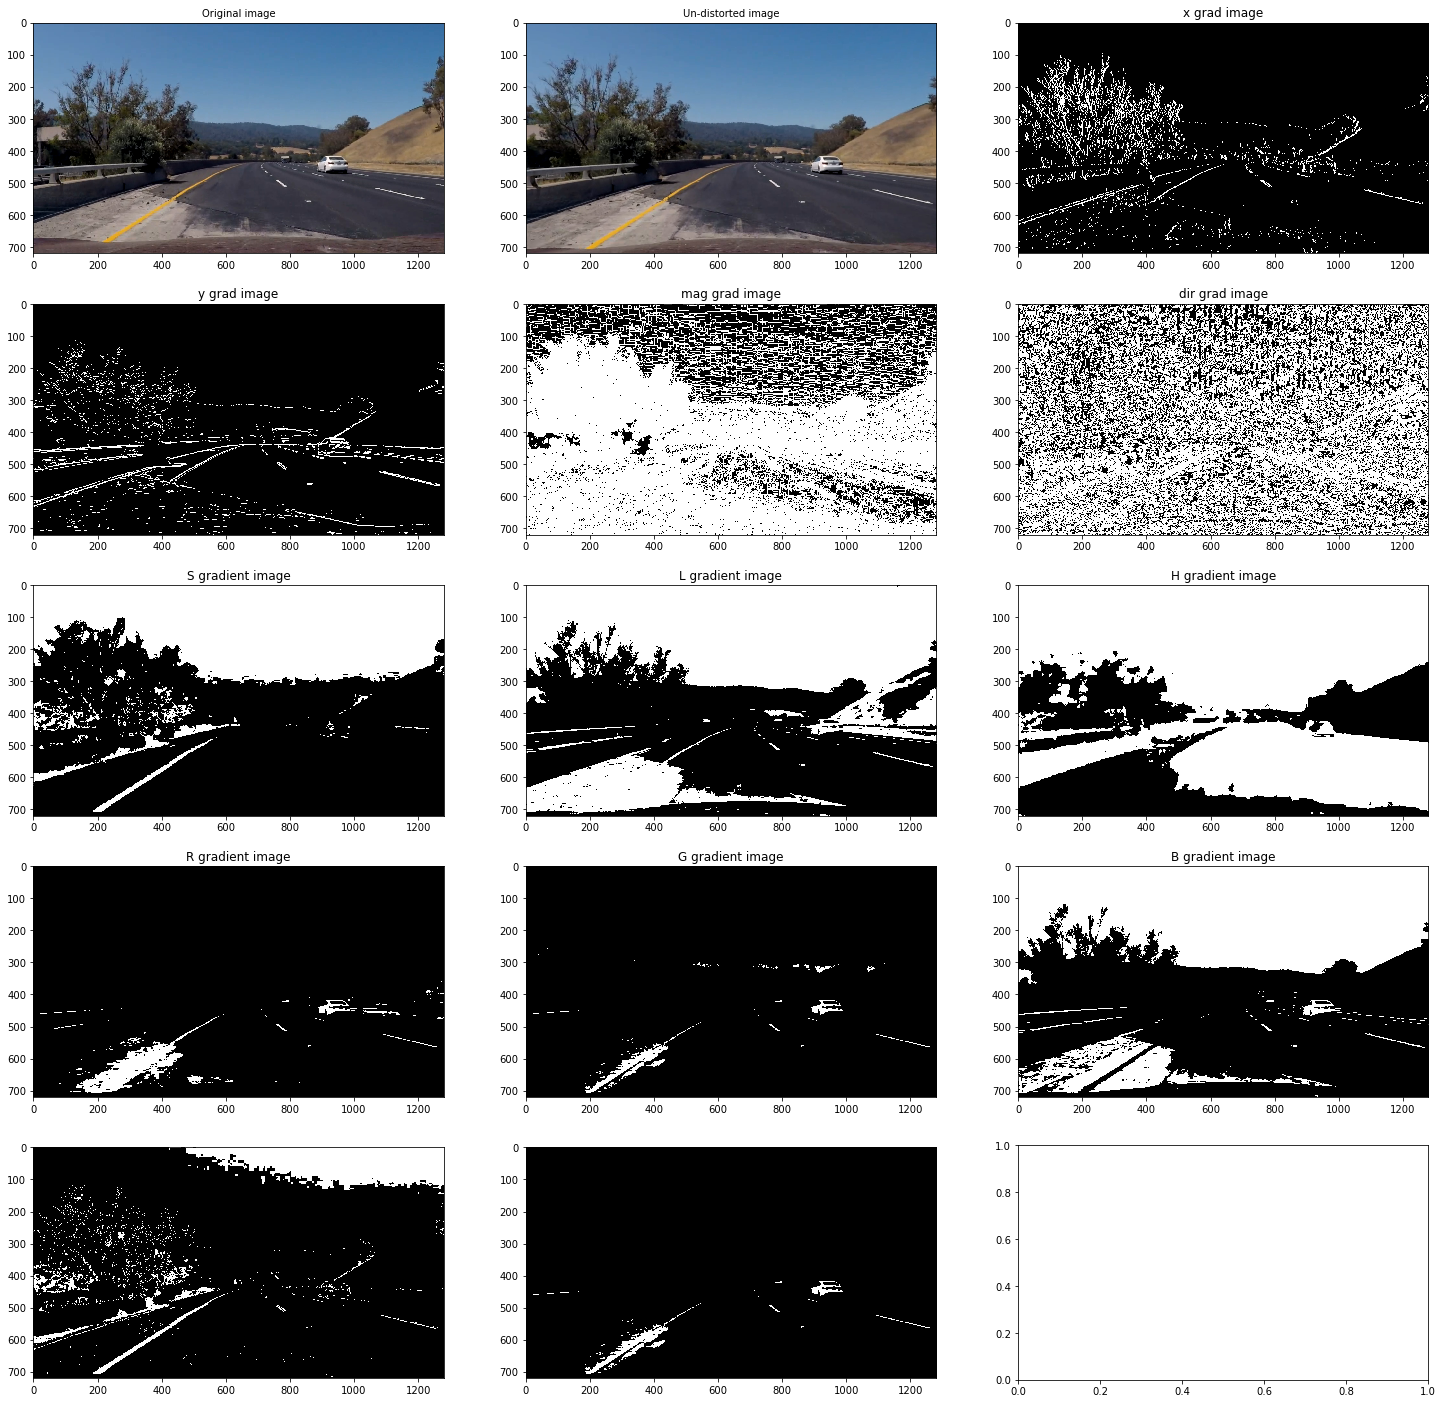

In [286]:
#Displaying all thresholding image
fig, axis = plt.subplots(5, 3, figsize=(25, 25))
axis[0, 0].imshow(lane_image)
axis[0, 0].set_title('Original image', fontsize =10)

axis[0, 1].imshow(lane_image_undist)
axis[0, 1].set_title('Un-distorted image', fontsize = 10)

axis[0, 2].imshow(x_gradient_img, 'gray')
axis[0, 2].set_title('x grad image')

axis[1, 0].imshow(y_gradient_img, 'gray')
axis[1, 0].set_title('y grad image')

axis[1, 1].imshow(magnitude_gradient_img, 'gray')
axis[1, 1].set_title('mag grad image')

axis[1, 2].imshow(direction_gradient_img, 'gray')
axis[1, 2].set_title('dir grad image')

axis[2, 0].imshow(s_gradient_img, 'gray')
axis[2, 0].set_title('S gradient image')

axis[2,1].imshow(l_gradient_img, 'gray')
axis[2,1].set_title('L gradient image')

axis[2, 2].imshow(h_gradient_img, 'gray')
axis[2, 2].set_title('H gradient image')

axis[3, 0].imshow(r_gradient_img, 'gray')
axis[3, 0].set_title('R gradient image')

axis[3, 1].imshow(g_gradient_img, 'gray')
axis[3, 1].set_title('G gradient image')

axis[3, 2].imshow(b_gradient_img, 'gray')
axis[3, 2].set_title('B gradient image')

axis[4,0].imshow(lane_shape, 'gray')

axis[4, 1].imshow(lane_color, 'gray')

In [290]:
def get_thresholded_image_area_of_interest(img):
    thresh_img = get_thresholded_image(img)
    
    height, width = thresh_img.shape

        
    region_of_interest = np.array([[width * 0.1, height * 1.0],\
                                   [width * 0.45, height * 0.40],\
                                   [width * 0.55, height * 0.40],\
                                   [width * 0.90, height * 1.0]]).astype(int)
    
    mask = np.zeros_like(thresh_img)
    #print(region_of_interest)
    cv2.fillPoly(mask, [region_of_interest], 1)
    masked_img_thresholded = cv2.bitwise_and(thresh_img, mask)
    
    return masked_img_thresholded

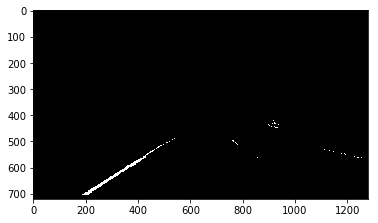

In [291]:
plt.imshow(get_thresholded_image(lane_image_undist), 'gray')

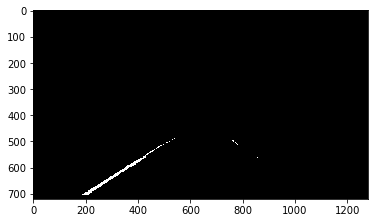

In [292]:
plt.imshow(get_thresholded_image_area_of_interest(lane_image_undist), 'gray')

### Apply perspective transform to rectify binary image

In [294]:
thresh_bin_img = get_thresholded_image_area_of_interest(lane_image_undist)

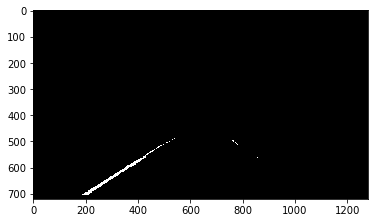

In [295]:
plt.imshow(thresh_bin_img, 'gray')

NameError: name 'x_0_img' is not defined

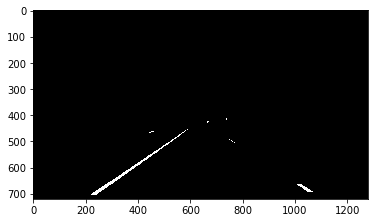

In [26]:
plt.imshow(thresh_bin_img, 'gray')
y_0_org = 680
x_0_org = x_0_img
y_1_org = y_0_org - 100
x_1_org = x_0_org
x_4_org = 1050
y_4_org = y_0_org
x_3_org = x_4_org
y_3_org = y_4_org - 120

plt.plot([x_0_org, x_1_org, x_3_org, x_4_org],[y_0_org, y_1_org, y_3_org, y_4_org])

y_0_img = 680
points = np.nonzero(thresh_bin_img[y_0_img])
x_0_img = 266

y_1_img = y_1_org + 9
x_1_img = 407

x_3_img = 880
y_3_img = y_3_org + 20

y_4_img = 670
x_4_img = 1030

#y_1_img = y_1_org
#x_1_img = np.nonzero(thresh_bin_img[y_1_img])[0][0]

plt.plot([x_0_img, x_1_img, x_3_img, x_4_img],[y_0_img, y_1_img, y_3_img, y_4_img],'*')

#plt.plot(x_0_img, y_0_img, '.')
#plt.plot(x_1_img, y_1_img, '.')

dest_point = np.float32([[x_0_org, y_0_org], [x_1_org, y_1_org], [x_3_org, y_3_org], [x_4_org, y_4_org]])
src_point = np.float32([[x_0_img, y_0_img], [x_1_img, y_1_img], [x_3_img, y_3_img], [x_4_img, y_4_img]])


In [28]:
dest_point

NameError: name 'dest_point' is not defined

In [29]:
persp_mtx = cv2.perspectiveTransform(src_point, dest_point)
warped = cv2.warpPerspective(thresh_bin_img, persp_mtx, (thresh_bin_img.shape[0], thresh_bin_img.shape[1]), flags = cv2.INTER_LINEAR)

NameError: name 'src_point' is not defined

In [30]:
persp_mtx

NameError: name 'persp_mtx' is not defined

In [31]:
thresh_bin_img[y_0_img]

NameError: name 'y_0_img' is not defined

In [96]:
bottom_left = [220,720]
bottom_right = [1110, 720]
top_left = [570, 470]
top_right = [722, 470]

source = np.float32([bottom_left,bottom_right,top_right,top_left])

bottom_left = [320,720]
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])
M = cv2.getPerspectiveTransform(source, dst)

img_size = (thresh_bin_img.shape[1], thresh_bin_img.shape[0])
warped = cv2.warpPerspective(thresh_bin_img, M, img_size , flags=cv2.INTER_LINEAR)

Minv = cv2.getPerspectiveTransform(dst, source)

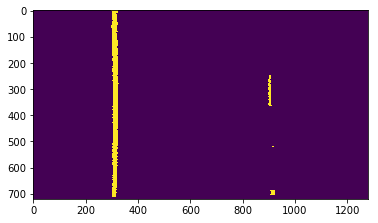

In [33]:
plt.imshow(warped)

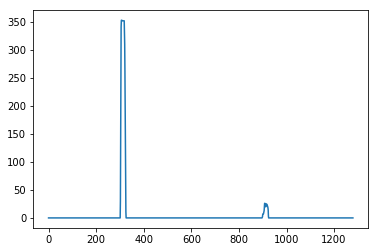

In [34]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [35]:
binary_warped = warped

In [36]:
def choose_pixel_of_binaryImg_by_histogram_analysis(binaryImg, x_startIndex, x_endIndex):
    histogram = np.sum(binaryImg[x_startIndex : x_endIndex, :], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_pix = np.argmax(histogram[:midpoint])
    rightx_pix = np.argmax(histogram[midpoint:]) + midpoint
    #plt.plot(histogram)
    return histogram, leftx_pix, rightx_pix

In [37]:
hist, left_pix, right_pixel = choose_pixel_of_binaryImg_by_histogram_analysis(binary_warped, 500, binary_warped.shape[0])

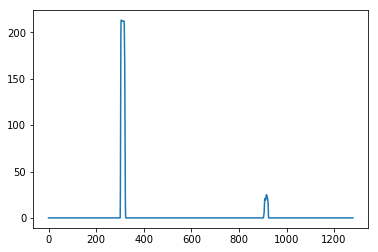

In [38]:
plt.plot(hist)

In [214]:
def get_line_predicted(binary_img, slid_win_count = 9, margin=100, minpix=50, draw_slidW_rect=False):
    # Take a histogram of bottom half of the image to choose bottom-left and bottom-right point.
    # This would work as starting point
    hist = np.sum(binary_img[binary_img.shape[0]/9:, :], axis=0)
    
    out_img = np.dstack((binary_img, binary_img, binary_img))*255
        
    midpoint = np.int(hist.shape[0]/2)
    bottom_left_x = np.argmax(hist[:midpoint])
    bottom_right_x = np.argmax(hist[midpoint:]) + midpoint
    
    window_height = np.int(binary_img.shape[0]/slid_win_count)
    
    leftx_current = bottom_left_x
    rightx_current = bottom_right_x
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = []
    right_lane_inds = []
    
    #Generating the rectangle boxes
    for window in range(slid_win_count):
        # Identify window boundaries in x and yboundary point (and right and left)
        win_y_low = binary_img.shape[0] - (window + 1) * window_height
        win_y_high = binary_img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw boundary rectangle
        if (draw_slidW_rect):
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
        # Identify non-zero pixel in sliding windows
        
        # Identify the x and y positions of all nonzero pixels in the image
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
            # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        #Choose center of mean the selected points of windows.
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            #print (leftx_current)
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

In [215]:
leftx_pixs, lefty_pixs, rightx_pixs, righty_pixs, outImage = get_line_predicted(binary_warped, draw_slidW_rect=False)

In [216]:
#plt.imshow(outImage)

In [217]:
def polynomial_fit(leftx_pixs, lefty_pixs, rightx_pixs, righty_pixs, y_axis_size):
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty_pixs, leftx_pixs, 2)
    right_fit = np.polyfit(righty_pixs, rightx_pixs, 2)
    
    ploty = np.linspace(0, y_axis_size -1 , y_axis_size )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [218]:
left_fitx, right_fitx, ploty = polynomial_fit(leftx_pixs, lefty_pixs, rightx_pixs, righty_pixs, warped.shape[0])

In [219]:
np.vstack([left_fitx, ploty]).T

array([[ 309.49843871,    0.        ],
       [ 309.52345966,    1.        ],
       [ 309.54841249,    2.        ],
       ..., 
       [ 309.95585201,  717.        ],
       [ 309.93203887,  718.        ],
       [ 309.90815761,  719.        ]])

(720, 0)

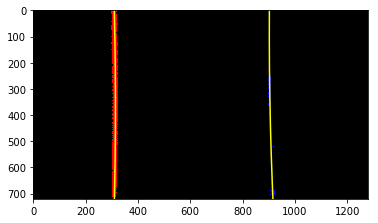

In [220]:
outImage[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
outImage[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(outImage)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [221]:
def lane_finding_pipeline(img, interm_images=False):
    # Get Un-Distorted Image
    img_undist = get_undistored(img, cam_mtx, cam_dist)
    
    # Get Thresholded Image from Un-distorted Image
    img_thresh = get_thresholded_image_area_of_interest(img_undist)
    
    # Get warped Image
    img_size = (thresh_bin_img.shape[1], thresh_bin_img.shape[0])
    img_warped = cv2.warpPerspective(img_thresh, M, img_size , flags=cv2.INTER_LINEAR)
    
    # Finding the points of left and right lane.
    leftx, lefty, rightx, righty, image_withrect = get_line_predicted(img_warped, draw_slidW_rect=interm_images)
    
    # Fit the polynomials for left and right lane
    left_fitx, right_fitx, ploty = polynomial_fit(leftx, lefty, rightx, righty, img_warped.shape[0])
    
    # Drawing the polynomials points on the original image
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
    
    outputs = {}
    outputs["result"] = result
    if interm_images:
        outputs["original"] = img
        outputs["undistort"] = img_undist
        outputs["threshold"] = img_thresh
        outputs["warped"] = img_warped
        outputs["image_slidingwindows"] = image_withrect
    return outputs
    

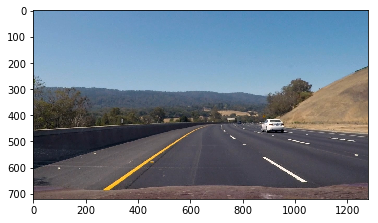

In [222]:
lane_image = cv2.imread('test_images/test3.jpg')
lane_image = cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB)
#plt.imshow(lane_image)
plt.imshow(lane_image)

In [223]:
outputs = lane_finding_pipeline(lane_image, interm_images=True)

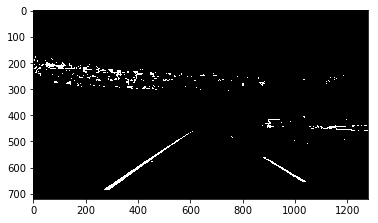

In [224]:
plt.imshow(get_thresholded_image(lane_image), 'gray')

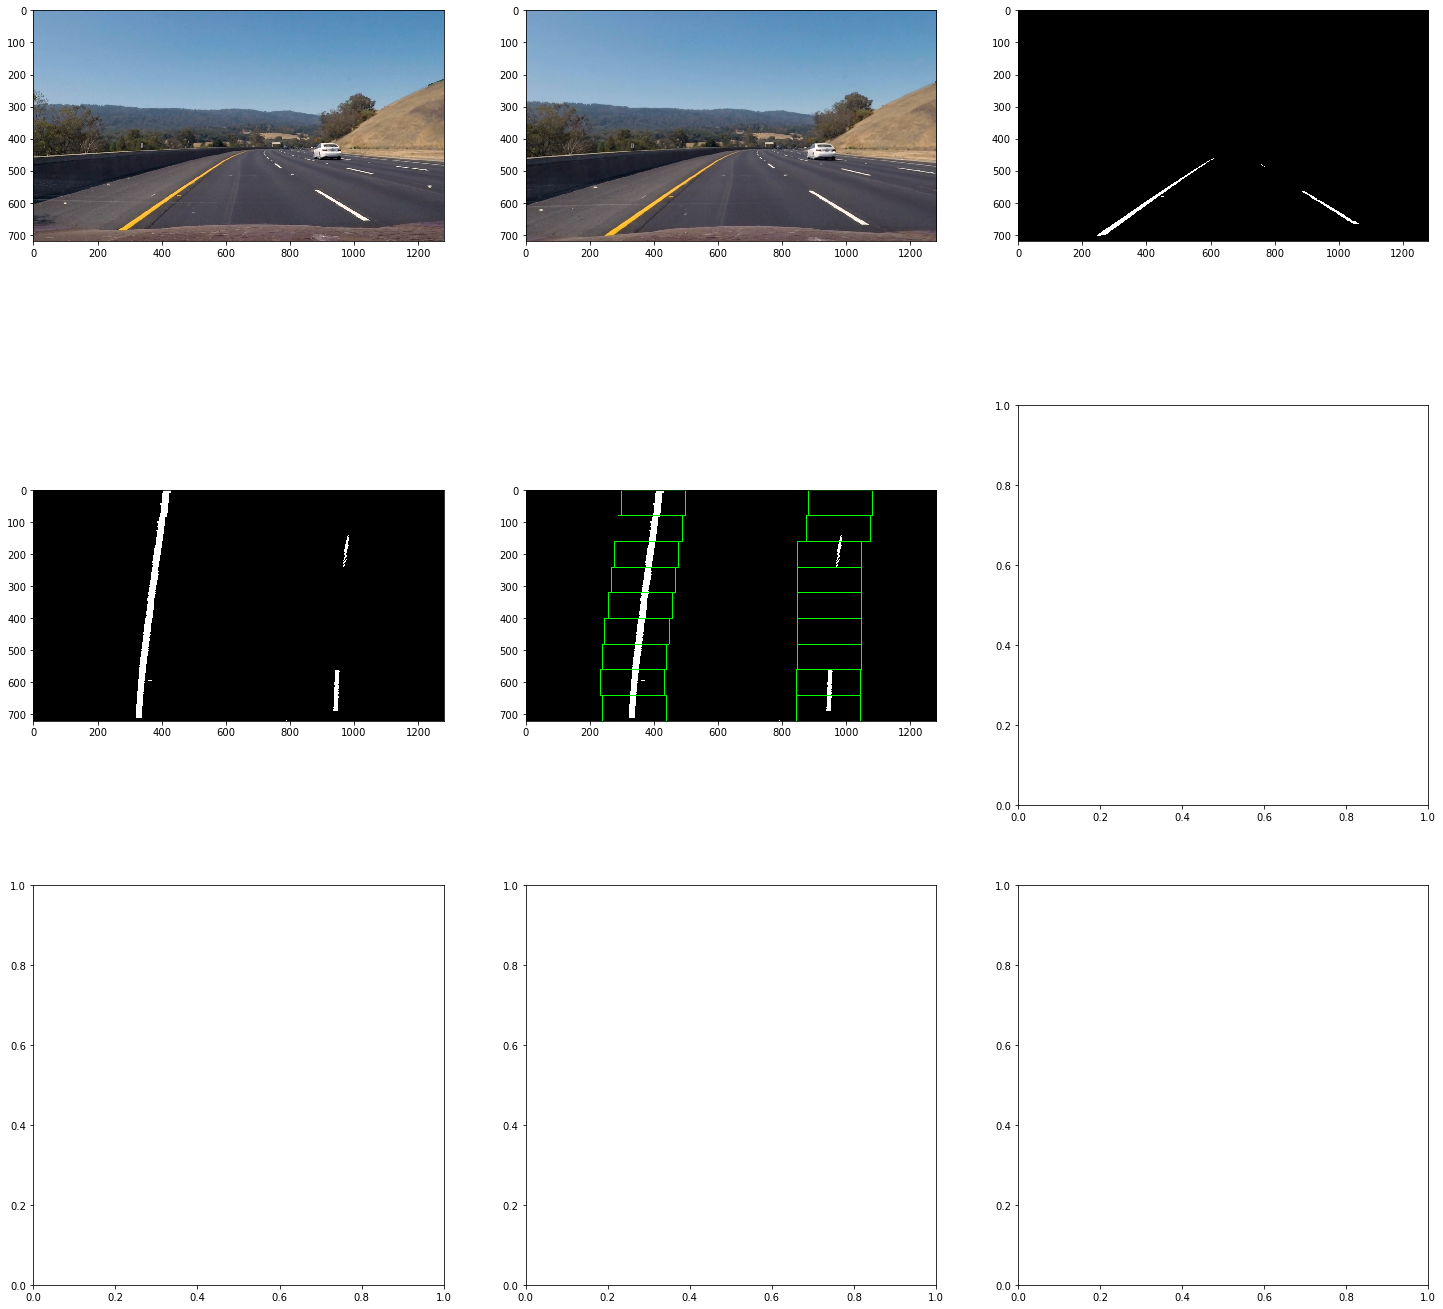

In [225]:
fig, axis = plt.subplots(3, 3, figsize=(25, 25))
axis[0, 0].imshow(lane_image)
#plt.imshow(outputs["undistort"])
axis[0,0].imshow(outputs["original"])
axis[0, 1].imshow(outputs["undistort"])
axis[0, 2].imshow(outputs["threshold"], 'gray')
axis[1,0].imshow(outputs["warped"], 'gray')
axis[1,1].imshow(outputs["image_slidingwindows"])
#axis[1, 1].imshow(outputs["result"])

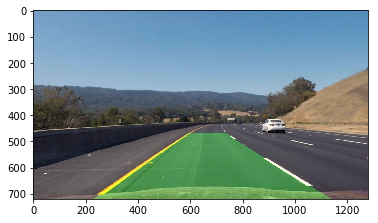

In [226]:
plt.imshow(outputs["result"])

In [227]:
failed_img = None

In [228]:
def process_image(image):
    global failed_img
    failed_img = image
    return lane_finding_pipeline(image)["result"]

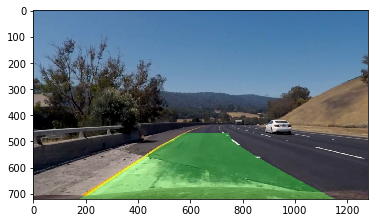

In [298]:
plt.imshow(process_image(failed_img))

In [299]:
plt.imshow(lan(failed_img), 'gray')

NameError: name 'lan' is not defined

In [300]:
white_output = 'project_video_withLaneMarking.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_withLaneMarking.mp4
[MoviePy] Writing video project_video_withLaneMarking.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:46,  7.57it/s]

  0%|          | 2/1261 [00:00<02:45,  7.61it/s]

  0%|          | 3/1261 [00:00<02:43,  7.69it/s]

  0%|          | 4/1261 [00:00<02:43,  7.71it/s]

  0%|          | 5/1261 [00:00<02:40,  7.82it/s]

  0%|          | 6/1261 [00:00<02:37,  7.98it/s]

  1%|          | 7/1261 [00:00<02:34,  8.10it/s]

  1%|          | 8/1261 [00:01<02:33,  8.16it/s]

  1%|          | 9/1261 [00:01<02:32,  8.23it/s]

  1%|          | 10/1261 [00:01<02:31,  8.24it/s]

  1%|          | 11/1261 [00:01<02:33,  8.12it/s]

  1%|          | 12/1261 [00:01<02:35,  8.05it/s]

  1%|          | 13/1261 [00:01<02:34,  8.05it/s]

  1%|          | 14/1261 [00:01<02:33,  8.10it/s]

  1%|          | 15/1261 [00:01<02:36,  7.98it/s]

  1%|▏         | 16/1261 [00:01<02:36,  7.94it/s]

  1%|▏         | 17/1261 [00:02<02:36,  7.96it/s]

  1%|▏         | 18/1261 [00:02<02:35,  7.99it/s]

  2%|▏         | 19/1261 [00:02<02:35,  8.00it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_withLaneMarking.mp4 

CPU times: user 10min 49s, sys: 28.4 s, total: 11min 18s
Wall time: 2min 57s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [301]:
white_output = 'harder_challenge_video_WithLaneMarking.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_WithLaneMarking.mp4
[MoviePy] Writing video harder_challenge_video_WithLaneMarking.mp4


 49%|████▉     | 590/1200 [01:21<01:13,  8.33it/s]

TypeError: expected non-empty vector for x